# Implement the EGO algorithm

In this example, we analyse the EGO algorithm and see its behaviour step by step.

## Acknowledgements

We thank Romain Espoeys (CEA) for sharing his script.

In [1]:
import numpy as np
import openturns as ot
import openturns.viewer as viewer

ot.ResourceMap.SetAsString("KrigingAlgorithm-LinearAlgebra", "LAPACK")
ot.Log.Show(ot.Log.NONE)

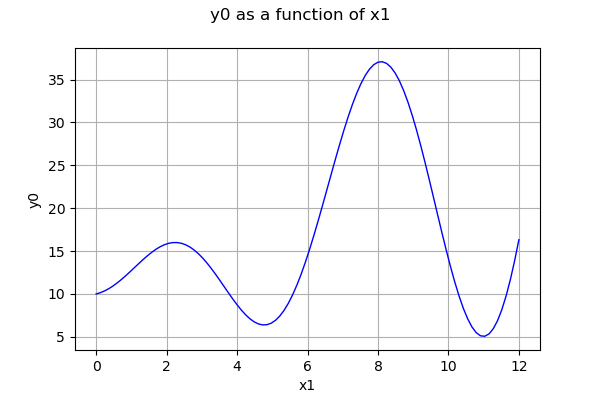

In [2]:
dim = 1
model = ot.SymbolicFunction(["x1"], ["10.0 + x1 + x1^2 / 20 + 2.0 * x1 * sin(x1)"])
model = ot.MemoizeFunction(model)
graph = model.draw(0.0, 12.0, 100)
graph

Create the training DOE.

In [3]:
training_sample_size = 5
x_train = ot.LHSExperiment(
    ot.Uniform(0, 12), training_sample_size, False, True
).generate()
y_train = model(x_train)

In [4]:
x_train

class=Sample name=Unnamed implementation=class=SampleImplementation name=Unnamed size=5 dimension=1 description=[X0] data=[[10.4329],[4.72662],[7.00963],[1.2073],[7.35169]]

Create a test sample.

In [5]:
xmin = 0.0
xmax = 12.0
test_sample_size = 200
step = (xmax - xmin) / (test_sample_size - 1)
myRegularGrid = ot.RegularGrid(xmin, step, test_sample_size)
x_test = myRegularGrid.getVertices()
y_test = model(x_test)

Kriging parameters.

In [6]:
dimension = 1
basis = ot.ConstantBasisFactory(dimension).build()
covarianceModel = ot.MaternModel([1.0] * dimension, 2.5)  # Matern_5/2

In [7]:
class ExpectedImprovementEvaluation(ot.OpenTURNSPythonFunction):
    """Defines the expected improvement criterion."""

    def __init__(self, optimalValue, krigingResult):
        """
        Create a ExpectedImprovementEvaluation.

        Parameters
        ----------
        optimalValue : float
            The best value so far.
        krigingResult : ot.KrigingResult
            The kriging metamodel.

        Returns
        -------
        None.
        """
        metamodel = krigingResult.getMetaModel()
        inputDimension = metamodel.getInputDimension()
        super(ExpectedImprovementEvaluation, self).__init__(inputDimension, 1)
        self.optimalValue = optimalValue
        self.krigingResult = krigingResult

    def _exec(self, x):
        """
        Evaluate the EI function at point x.

        Parameters
        ----------
        x : ot.Point
            The input point.

        Returns
        -------
        expectedImprovement : ot.Point(1)
            The value of the expected improvement.

        """
        mx = self.krigingResult.getConditionalMean(x)[0]
        fmMk = self.optimalValue - mx
        sk2 = self.krigingResult.getConditionalMarginalVariance(x)
        sk = np.sqrt(sk2)
        ratio = fmMk / sk
        ei = fmMk * ot.DistFunc.pNormal(ratio) + sk * ot.DistFunc.dNormal(ratio)
        return [ei]

EGO algorithm.

In [8]:
number_of_EGO_iterations = 1
bounds = ot.Interval([0.0] * dimension, [12.0] * dimension)
iteration_index = 1
while iteration_index <= number_of_EGO_iterations:
    # Evaluate the DOE minimum
    y_min = y_train.getMin()[0]
    # Kriging
    kriging = ot.KrigingAlgorithm(x_train, y_train, covarianceModel, basis)
    kriging.run()
    krigingResult = kriging.getResult()
    krigeageMM = krigingResult.getMetaModel()
    y_test_MM = krigeageMM(x_test)
    # Evaluate Expected Improvement
    evaluationEI = ExpectedImprovementEvaluation(y_min, krigingResult)
    functionEI = ot.Function(evaluationEI)
    y_test_EI = functionEI(x_test)
    # Calculate argmax(EI) and get the value of x_new
    argmax_EI = y_test_EI.getMax()
    i = y_test_EI.find(argmax_EI)
    x_new = x_test[i]
    # Calculate y_new = fonction(x_new), x_new=sample and y_new=sample
    x_new_sample = ot.Sample(1, x_new)
    y_new_sample = model(x_new_sample)
    # Add this new point (x_new_sample,y_new_sample) to the DOE
    x_train.add(x_new_sample)
    y_train.add(y_new_sample)
    iteration_index += 1

In [9]:
# Get (x_opt,y_opt) the optimal point
y_opt = y_train.getMin()
i = y_train.find(y_opt)
x_opt = x_train[i]
print("x_opt = ", x_opt)
print("y_opt = ", y_opt)

x_opt =  [4.72662]
y_opt =  [6.39139]


Plot.

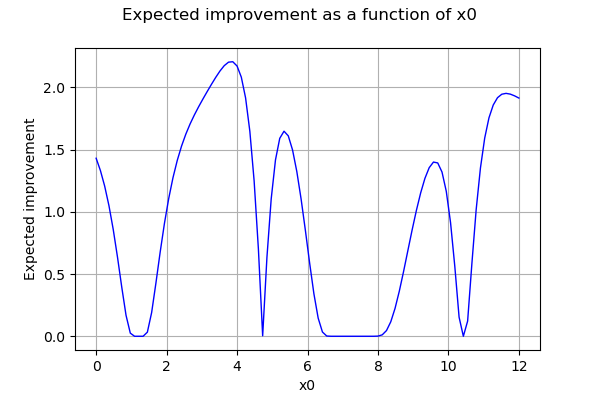

In [10]:
functionEI.setInputDescription(krigingResult.getMetaModel().getInputDescription())
functionEI.setOutputDescription(["Expected improvement"])
graph = functionEI.draw(0.0, 12.0, 100)
graph

In [11]:
def plot_data_train(x_train, y_train):
    graph_train = ot.Cloud(x_train, y_train)
    graph_train.setColor("red")
    graph_train.setLegend("DOE")
    return graph_train


def plot_data_ego(x_opt, y_opt):
    graph_ego = ot.Cloud(x_opt, y_opt)
    graph_ego.setPointStyle("diamond")
    graph_ego.setColor("forestgreen")
    graph_ego.setLegend("EGO")
    return graph_ego


def plot_data_test(x_test, y_test):
    graphF = ot.Curve(x_test, y_test)
    graphF.setLegend("Function")
    graphF.setColor("black")
    graphF.setLineStyle("dashed")
    return graphF

def plot_data_kriging(x_test, y_test_MM):
    graphK = ot.Curve(x_test, y_test_MM)
    graphK.setColor("blue")
    graphK.setLegend("Kriging MM")
    return graphK

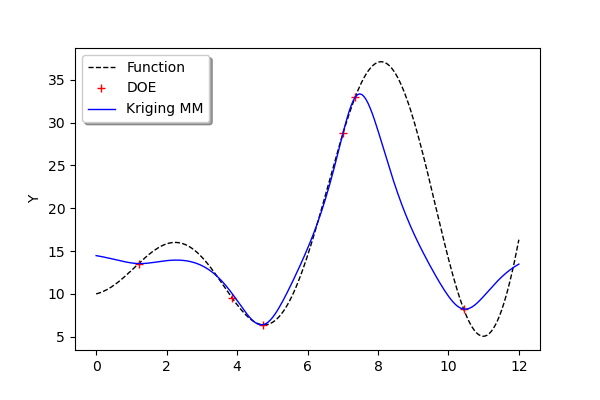

In [12]:
graph = ot.Graph()
graph.add(plot_data_test(x_test, y_test))
graph.add(plot_data_train(x_train, y_train))
graph.add(plot_data_kriging(x_test, y_test_MM))
graph.setAxes(True)
graph.setYTitle("Y")
graph.setLegendPosition("topleft")
graph